In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers==4.46.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.8 MB/s eta 0:00:00


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
#import evaluate
#import optuna
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
#from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    Adafactor, get_linear_schedule_with_warmup
)
from sentence_transformers import SentenceTransformer,  InputExample, LoggingHandler
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/Model for benchmark/data/train - train (3).csv')

In [ ]:
data_train = data_train.drop(columns=['Unnamed: 0'])

In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/Model for benchmark/data/test_data.csv')

In [ ]:
data_test = data_test.drop(columns=['Unnamed: 0'])

In [ ]:
data_train

,message.text,Оценка
0,Сестринское дело (1991). Перевоспитание (2020)...,2
1,"Не указано, Опыт работы: 0,5 года, Компания: К...",2
2,"Коммуникабельный, стрессоустойчивый и пунктуал...",2
3,Косметолог с опытом работы в салоне. Мне нрави...,2
4,"**Обязанности:** * Чистка лица (механическая, ...",2
...,...,...
3356,"Косметолог с 9-летним опытом, увлеченный своей...",3
3357,Косметолог с опытом работы 2.8 года. Имею высш...,6
3358,"Не указано,Стаж работы: 2.1,Компания: Здоровье...",5
3359,"По образованию фельдшер-лаборант, стаж работы ...",8


In [ ]:
X = data_train['message.text']
y = data_train['Оценка']
X_test = data_test['message.text']
y_test = data_test['Оценка']

#Предобработка

In [ ]:
def convert_emojis_to_words(text):

    # Convert emojis to words
    text = emoji.replace_emoji(text, replace="")
    # Remove the : from the words and replace _ with space
    text = text.replace("_", " ")

    return text

In [ ]:
symbols_pattern = re.compile(pattern = "["
    "@_!#$%^&*()<>?/\|}{~√•—"
                       "]+", flags = re.UNICODE) #спецсимволы
# двойные пробелы
space_pattern = re.compile('\s+')

In [ ]:
def clear_text(text):
    """ Функция удаления спецсимволов"""
    # удаление спецсимволов и emoji
    pre = symbols_pattern.sub(r'',text)
    pre = re.sub(r'http\S+', '', pre)
    pre = convert_emojis_to_words(pre)

    return space_pattern.sub(' ', pre)

In [ ]:
def preprocess_text(text):
    """ Финальная функция для обработки """
    # srip + lower + punctuation
    sentence = (
        ''.join([x for x in str(text).strip().lower()])
    )

    return clear_text(sentence)

In [ ]:
data_train['message.text'] = data_train['message.text'].apply(preprocess_text)

In [ ]:
X = X.apply(preprocess_text)

In [ ]:
X_test = X_test.apply(preprocess_text)

In [ ]:
df_train, df_val = train_test_split(data_train, test_size=0.1, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Fine tuning Sentence Transformer

In [ ]:
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [ ]:
class ClassificationHead(nn.Module):
  def __init__(self, embedding_dim, num_classes):
    super(ClassificationHead, self).__init__()
    self.linear = nn.Linear(embedding_dim, num_classes)
  def forward(self, data):
    x = data['sentence_embedding']
    x = self.linear(x)
    return x

num_labels = 9
classification_head = ClassificationHead(model.get_sentence_embedding_dimension(), num_labels)

In [ ]:
class SentenceTransformerplusHead(nn.Module):
  def __init__(self, transformer, classification_head):
    super(SentenceTransformerplusHead, self).__init__()
    self.transformer = transformer
    self.classification_head = classification_head
  def forward(self, input):
    data = self.transformer(input)
    logits = self.classification_head(data)
    return logits

In [ ]:
sentence_transformer_plus_head = SentenceTransformerplusHead(model, classification_head)

In [ ]:
# training parameters
num_epochs = 100
batch_size = 32
learning_rate = 1e-3


In [ ]:
# Convert the dataset to PyTorch tensors.
train_examples = [InputExample(texts=[s], label=l) for s, l in zip(X, y)]

# Customize collate_fn to convert InputExample objects into tensors.
def collate_fn(batch):
    texts = [example.texts[0] for example in batch]
    labels = torch.tensor([example.label for example in batch])
    return texts, labels

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)

# Define the loss function, optimizer, and learning rate scheduler.
criterion = nn.CrossEntropyLoss()
optimizer = Adafactor(sentence_transformer_plus_head.parameters(), relative_step=False, lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
loss_list=[]
for epoch in range(num_epochs):
    sentence_transformer_plus_head.train()
    for step, (texts, labels) in enumerate(train_dataloader):
        labels = labels.to(model.device)
        optimizer.zero_grad()

        # Encode text and pass through classification head.
        inputs = model.tokenize(texts)
        input_ids = inputs['input_ids'].to(model.device)
        input_attention_mask = inputs['attention_mask'].to(model.device)
        inputs_final = {'input_ids': input_ids, 'attention_mask': input_attention_mask}

        # move model_with_head to the same device
        sentence_transformer_plus_head = sentence_transformer_plus_head.to(model.device)
        logits = sentence_transformer_plus_head(inputs_final)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if step % 500 == 0:
            print(f"Epoch {epoch}, Step {step}, Loss: {loss.item()}")

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    model_save_path = '//content/drive/MyDrive/finetuning_sentance_transformer_plus_head11/'
    model.save(model_save_path)
    loss_list.append(loss.item())

Epoch 0, Step 0, Loss: 2.1931676864624023
Epoch 1/100, Loss: 1.7126953601837158
Epoch 1, Step 0, Loss: 1.8443498611450195
Epoch 2/100, Loss: 1.6434390544891357
Epoch 2, Step 0, Loss: 1.6796295642852783
Epoch 3/100, Loss: 1.574171781539917
Epoch 3, Step 0, Loss: 1.5726817846298218
Epoch 4/100, Loss: 1.5019654035568237
Epoch 4, Step 0, Loss: 1.528631567955017
Epoch 5/100, Loss: 1.3847715854644775
Epoch 5, Step 0, Loss: 1.561138391494751
Epoch 6/100, Loss: 1.3476520776748657
Epoch 6, Step 0, Loss: 1.4836686849594116
Epoch 7/100, Loss: 1.3102333545684814
Epoch 7, Step 0, Loss: 1.4565203189849854
Epoch 8/100, Loss: 1.2215681076049805
Epoch 8, Step 0, Loss: 1.2731568813323975
Epoch 9/100, Loss: 1.1795796155929565
Epoch 9, Step 0, Loss: 1.1914042234420776
Epoch 10/100, Loss: 1.058637022972107
Epoch 10, Step 0, Loss: 1.1017838716506958
Epoch 11/100, Loss: 1.2849208116531372
Epoch 11, Step 0, Loss: 1.0550576448440552
Epoch 12/100, Loss: 0.9595960378646851
Epoch 12, Step 0, Loss: 1.1448750495910

In [ ]:
# Save the final model
model_final_save_path='//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/st_ft1_epoch100'
model.save(model_final_save_path)

In [ ]:
y_train = np.array(y)
y_test = np.array(y_test)

In [ ]:
X_train

,message.text
1662,"доброжелательная, коммуникабельная, трудолюбив..."
1988,косметолог-эстетист с опытом работы 3 года. на...
3175,"дисциплинированность, доброжелательность, обуч..."
1972,обо мне: молодая косметолог с дипломом высшего...
926,косметолог-эстетист. владею несколькими видами...
...,...
1095,"трудолюбивая, нахожу общий язык с пациентами, ..."
1130,обучаю косметологов с выдачей диплома государ...
1294,знание техник классического и лифтинг-массажа ...
860,обязанности: все должностные обязанности. орг...


# Обучение и тестирование XGBoost

In [ ]:
model = SentenceTransformer('//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/st_ft_epoch100')

In [ ]:
train_embeddings  = X_train.apply(lambda x: model.encode(str(x))).to_list()
val_embeddings  = X_val.apply(lambda x: model.encode(str(x))).to_list()
test_embeddings  = X_test.apply(lambda x: model.encode(str(x))).to_list()

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [ ]:
train_embeddings = np.array(train_embeddings)
val_embeddings = np.array(val_embeddings)
test_embeddings = np.array(test_embeddings)

In [ ]:
xgb1 = XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.07078025811321921, max_depth=45, n_estimators = 700, subsample=0.5458605221291573, colsample_bytree= 0.15268221810604315)
# Предсказания и оценка
xgb1.fit(train_embeddings, y_train,eval_set= [(train_embeddings, y_train), (val_embeddings, y_val)])

y_pred = xgb1.predict(test_embeddings)

[0]	validation_0-mlogloss:1.92104	validation_1-mlogloss:1.92405
[1]	validation_0-mlogloss:1.71324	validation_1-mlogloss:1.72397
[2]	validation_0-mlogloss:1.54702	validation_1-mlogloss:1.56054
[3]	validation_0-mlogloss:1.40964	validation_1-mlogloss:1.42772
[4]	validation_0-mlogloss:1.29199	validation_1-mlogloss:1.31541
[5]	validation_0-mlogloss:1.18923	validation_1-mlogloss:1.21638
[6]	validation_0-mlogloss:1.09895	validation_1-mlogloss:1.12990
[7]	validation_0-mlogloss:1.01809	validation_1-mlogloss:1.05188
[8]	validation_0-mlogloss:0.94558	validation_1-mlogloss:0.98284
[9]	validation_0-mlogloss:0.88035	validation_1-mlogloss:0.92252
[10]	validation_0-mlogloss:0.82100	validation_1-mlogloss:0.86708
[11]	validation_0-mlogloss:0.76685	validation_1-mlogloss:0.81606
[12]	validation_0-mlogloss:0.71790	validation_1-mlogloss:0.76969
[13]	validation_0-mlogloss:0.67218	validation_1-mlogloss:0.72673
[14]	validation_0-mlogloss:0.63085	validation_1-mlogloss:0.68788
[15]	validation_0-mlogloss:0.59217	

In [ ]:
evals_result = xgb1.evals_result()

In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred, average='weighted'))

Accuracy : 0.857707509881423
F1 score: 0.8588856414178312


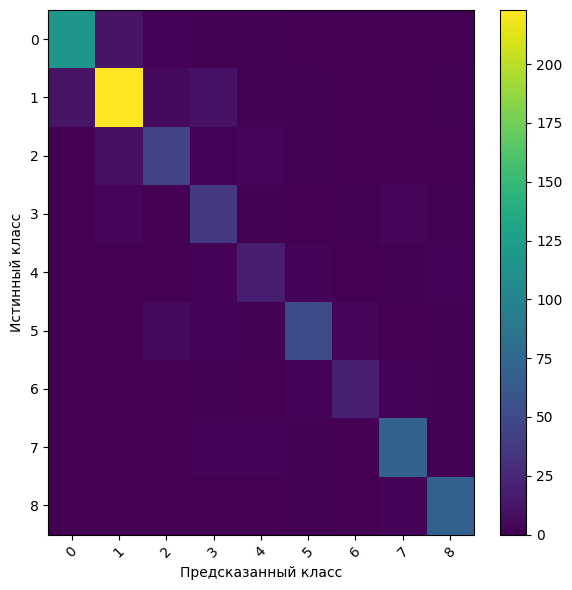

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto')
unique_labels = np.unique(y_test).astype(int)
ax.set_xticks(range(9))
ax.set_yticks(range(9))
ax.set_xticklabels(unique_labels, rotation=45)
ax.set_yticklabels(unique_labels)
ax.set_ylabel('Истинный класс')
ax.set_xlabel('Предсказанный класс')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
plt.savefig('xbg_matrix.png')


In [ ]:
# Сначала получим список всех классов
classes = np.unique(y_test)

# 1) F1-score по классам
f1_per_class = f1_score(y_test, y_pred, labels=classes, average=None, zero_division=0)

# 2) «Точность по классу» как доля правильно предсказанных среди всех примеров этого класса
#    (этот показатель в мультиклассе эквивалентен recall для данного класса)
accuracy_per_class = np.array([
    np.mean(y_pred[y_test == cls] == cls)
    for cls in classes
])

# 3) Собираем всё в DataFrame
df = pd.DataFrame({
    'class': classes.astype(str),
    'accuracy': accuracy_per_class,
    'f1_score': f1_per_class
}).set_index('class')

print(df)



       accuracy  f1_score
class                    
0      0.879699  0.893130
1      0.874510  0.888446
2      0.737705  0.750000
3      0.808511  0.716981
4      0.708333  0.666667
5      0.800000  0.832000
6      0.769231  0.800000
7      0.921053  0.909091
8      0.958333  0.932432


# Оптимизация гиперпараметров XGBoost и повторное обучение

In [ ]:
def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 9,
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0)
    }

    model = XGBClassifier(**params)
    model.fit(train_embeddings, y_train)

    y_pred = model.predict(val_embeddings)
    return accuracy_score(y_val, y_pred)

# Запуск оптимизации
study = optuna.create_study(direction="maximize")  # Ищем max accuracy
study.optimize(objective, n_trials=50)

# Лучшие параметры
print("Лучшие параметры:", study.best_params)

[I 2025-05-17 11:53:46,762] A new study created in memory with name: no-name-49b94188-7b2a-4248-8b03-c603c052211f
<ipython-input-67-654edcda1c69>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.3),
[I 2025-05-17 11:56:26,541] Trial 0 finished with value: 0.9436201780415431 and parameters: {'learning_rate': 0.01290759216337266, 'max_depth': 94, 'n_estimators': 1214, 'subsample': 0.9314412715656059, 'colsample_bytree': 0.28506384876791646}. Best is trial 0 with value: 0.9436201780415431.
<ipython-input-67-654edcda1c69>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_logun

Лучшие параметры: {'learning_rate': 0.005571440502204253, 'max_depth': 11, 'n_estimators': 140, 'subsample': 0.6473257042288756, 'colsample_bytree': 0.14967908315900308}


In [ ]:
xgb2 =XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.005571440502204253, max_depth=11, n_estimators = 140, subsample=0.6473257042288756, colsample_bytree = 0.14967908315900308)

In [ ]:
xgb2.fit(train_embeddings, y_train,eval_set= [(train_embeddings, y_train), (val_embeddings, y_val)])

[0]	validation_0-mlogloss:2.17495	validation_1-mlogloss:2.17524
[1]	validation_0-mlogloss:2.15307	validation_1-mlogloss:2.15387
[2]	validation_0-mlogloss:2.13167	validation_1-mlogloss:2.13284
[3]	validation_0-mlogloss:2.11078	validation_1-mlogloss:2.11241
[4]	validation_0-mlogloss:2.09038	validation_1-mlogloss:2.09262
[5]	validation_0-mlogloss:2.07032	validation_1-mlogloss:2.07312
[6]	validation_0-mlogloss:2.05075	validation_1-mlogloss:2.05381
[7]	validation_0-mlogloss:2.03154	validation_1-mlogloss:2.03513
[8]	validation_0-mlogloss:2.01273	validation_1-mlogloss:2.01676
[9]	validation_0-mlogloss:1.99437	validation_1-mlogloss:1.99894
[10]	validation_0-mlogloss:1.97626	validation_1-mlogloss:1.98163
[11]	validation_0-mlogloss:1.95848	validation_1-mlogloss:1.96419
[12]	validation_0-mlogloss:1.94122	validation_1-mlogloss:1.94728
[13]	validation_0-mlogloss:1.92409	validation_1-mlogloss:1.93071
[14]	validation_0-mlogloss:1.90740	validation_1-mlogloss:1.91474
[15]	validation_0-mlogloss:1.89082	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.14967908315900308, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005571440502204253,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=140, n_jobs=None, num_class=9,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb2.predict(test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.89328


In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred, average='weighted'))

Accuracy : 0.8932806324110671
F1 score: 0.8934317034050271


In [ ]:
classes = np.unique(y_test)

# 1) F1-score по классам
f1_per_class = f1_score(y_test, y_pred, labels=classes, average=None, zero_division=0)

# 2) «Точность по классу» как доля правильно предсказанных среди всех примеров этого класса
#    (этот показатель в мультиклассе эквивалентен recall для данного класса)
accuracy_per_class = np.array([
    np.mean(y_pred[y_test == cls] == cls)
    for cls in classes
])

# 3) Собираем всё в DataFrame
df = pd.DataFrame({
    'class': classes.astype(str),
    'accuracy': accuracy_per_class,
    'f1_score': f1_per_class
}).set_index('class')

print(df)

       accuracy  f1_score
class                    
0      0.894737  0.884758
1      0.882353  0.905433
2      0.836066  0.816000
3      0.957447  0.873786
4      0.833333  0.833333
5      0.876923  0.883721
6      0.730769  0.844444
7      0.947368  0.941176
8      0.958333  0.926174


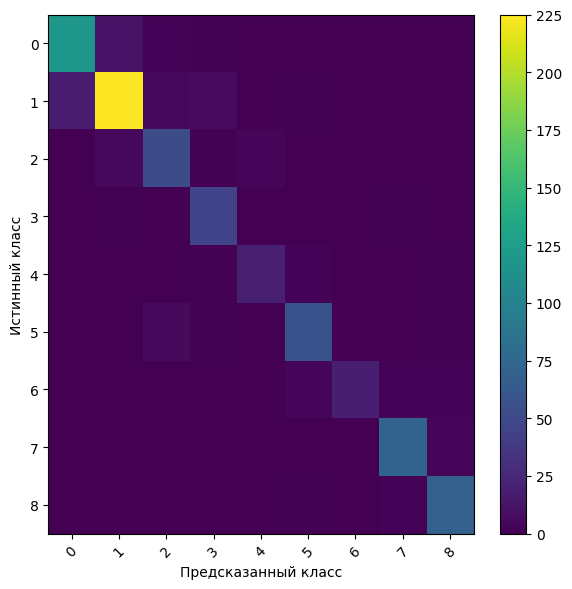

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto')
unique_labels = np.unique(y_test).astype(int)
ax.set_xticks(range(9))
ax.set_yticks(range(9))
ax.set_xticklabels(unique_labels, rotation=45)
ax.set_yticklabels(unique_labels)
ax.set_ylabel('Истинный класс')
ax.set_xlabel('Предсказанный класс')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
plt.savefig('xbg_matrix.png')

# Формирование файла Pickle

In [ ]:
class Preprocessing:
    def __init__(self):
        """
        :param text: исходная строка для предварительной обработки
        """
        pass
    def fit(self, text,y=None):
      return self

    def make_string(self,text):
        """
        Приводит текст к строке, удаляет лишние пробелы и приводит к нижнему регистру
        """
        return str(text).strip().lower()

    def convert_emojis_to_words(self, text=None):
        """
        Преобразует emojis в слова
        :param text: текст для обработки; если None, используется self.text
        """
        t = text if text is not None else text
        # Переводим emoji в текстовый формат :emoji_name:
        text_1 = emoji.demojize(str(t), delimiters=(" ", " "))
        # Удаляем двоеточия и заменяем подчёркивания на пробелы
        text_1 = text_1.replace(':', '').replace('_', ' ')
        return text_1

    def clear_text(self, text):
        """
        Удаляет спецсимволы и нормализует пробелы
        :param text: текст для очистки
        """
        symbols_pattern = re.compile(r"[@_!#$%^&*()<>?/\\|}{~√•—]+", flags=re.UNICODE)
        space_pattern = re.compile(r"\s+")
        # Удаляем спецсимволы
        pre = symbols_pattern.sub('', text)
        # Нормализуем пробелы
        return space_pattern.sub(' ', pre).strip()

    def transform(self,text):
        """
        Полная предварительная обработка текста:
        - stringify + lower
        - convert emojis
        - clear text
        :returns: обработанная строка
        """
        s = self.make_string(text)
        s = self.convert_emojis_to_words(s)
        s = self.clear_text(s)
        return s



In [ ]:
class Get_embeddings:
  def __init__(self):
    self.model = SentenceTransformer('//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/st_ft_epoch100')
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    train_embeddings  = list(model.encode(X))
    return train_embeddings

In [ ]:
xgb1 =XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.005571440502204253, max_depth=11, n_estimators = 140, subsample=0.6473257042288756, colsample_bytree = 0.14967908315900308)

In [ ]:
xgb2 =XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.005571440502204253, max_depth=11, n_estimators = 140, subsample=0.6473257042288756, colsample_bytree = 0.14967908315900308)

In [ ]:
from sklearn.pipeline import Pipeline
import pickle

In [ ]:
pipe = Pipeline([('get_embeddings', Get_embeddings()),
                 ('xgb', xgb2)])

In [ ]:
pipe.fit(X, y)

Pipeline(steps=[('get_embeddings',
                 <__main__.Get_embeddings object at 0x7dcec84fd4d0>),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.14967908315900308,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, gro...=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005571440502204253, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=11,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=140,
                               n_jobs=None, num_class=9, num_parallel_tree=None, ...))])

In [ ]:
with open('xgb_model2.pkl', 'wb') as output:
    pickle.dump(pipe, output)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
# Десериализуем pipeline из файла
with open('/content/drive/MyDrive/xgb_model2.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

In [ ]:
pred = loaded_pipe.predict(X_test)

In [ ]:
print("Accuracy :", accuracy_score(y_test, pred))
print("F1 score:",f1_score(y_test, pred, average='weighted'))

In [ ]:
model = SentenceTransformer('//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/st_ft_epoch100')

In [ ]:
train_embeddings  = X_train.apply(lambda x: model.encode(str(x))).to_list()
test_embeddings  = X_test.apply(lambda x: model.encode(str(x))).to_list()

In [ ]:
xgb1 =XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.005571440502204253, max_depth=11, n_estimators = 140, subsample=0.6473257042288756, colsample_bytree = 0.14967908315900308)

In [ ]:
xgb1.fit(train_embeddings, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.14967908315900308, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005571440502204253,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=140, n_jobs=None, num_class=9,
              num_parallel_tree=None, ...)

In [ ]:
y_test = np.array(y_test)

In [ ]:
y_test

array([1, 1, 1, 4, 1, 0, 7, 2, 3, 4, 8, 7, 0, 0, 0, 1, 2, 1, 3, 7, 3, 2,
       5, 5, 2, 2, 2, 1, 5, 7, 5, 7, 8, 1, 7, 3, 5, 0, 4, 0, 5, 1, 7, 8,
       2, 2, 0, 4, 3, 7, 1, 4, 0, 2, 6, 4, 1, 1, 2, 8, 7, 7, 4, 4, 6, 1,
       5, 8, 7, 8, 3, 3, 5, 8, 6, 3, 3, 6, 8, 7, 7, 1, 1, 5, 0, 7, 2, 6,
       4, 7, 0, 0, 3, 1, 5, 6, 5, 8, 7, 0, 1, 0, 8, 0, 8, 3, 2, 4, 8, 0,
       0, 1, 2, 6, 0, 2, 1, 6, 1, 2, 4, 0, 1, 0, 7, 6, 0, 1, 5, 1, 6, 2,
       5, 8, 1, 8, 2, 5, 7, 2, 0, 7, 3, 2, 0, 1, 7, 8, 5, 6, 5, 6, 1, 3,
       6, 4, 6, 5, 6, 8, 6, 0, 1, 0, 8, 0, 2, 1, 4, 4, 4, 1, 0, 3, 0, 0,
       5, 5, 4, 5, 1, 5, 2, 1, 0, 8, 2, 3, 7, 2, 5, 1, 1, 0, 8, 8, 5, 2,
       1, 1, 2, 0, 5, 2, 7, 6, 1, 7, 1, 2, 3, 8, 2, 5, 7, 5, 3, 2, 7, 3,
       0, 8, 5, 2, 5, 0, 6, 0, 1, 3, 4, 1, 8, 8, 4, 8, 0, 2, 6, 8, 2, 1,
       4, 8, 5, 4, 3, 7, 7, 0, 4, 7, 2, 7, 8, 6, 2, 3, 7, 0, 3, 1, 8, 1,
       5, 5, 8, 7, 5, 0, 4, 1, 3, 1, 4, 4, 4, 8, 1, 4, 0, 4, 8, 1, 1, 0,
       3, 1, 1, 7, 1, 1, 0, 4, 3, 4, 1, 0, 1, 8, 4,

In [ ]:
data_test['prediction'] = xgb1.predict(test_embeddings)

In [ ]:
print("Accuracy :", accuracy_score(data_test['Оценка'], data_test['prediction']))
print("F1 score:",f1_score(data_test['Оценка'], data_test['prediction'], average='weighted'))

Accuracy : 0.8932806324110671
F1 score: 0.8934317034050271
